# Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-66f06defed7f>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# https://www.kaggle.com/pinardogan/time-series-using-lightgbm-with-explanations
# https://timeseriesreasoning.com/contents/regression-with-arima-errors-model/
# https://machinelearningmastery.com/model-residual-errors-correct-time-series-forecasts-python/

# Read data, preprocessing and time series feature extraction

In [3]:
store_df = pd.read_csv("store.csv")
data_df = pd.read_csv("train.csv")

In [4]:
store_df.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
data_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
print(data_df.isna().sum())
print(store_df.isna().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [7]:
# Preliminary date transformations
data_df["Date"] = pd.to_datetime(data_df["Date"])
data_df["Year"] = data_df.Date.dt.year
data_df["Month"] = data_df.Date.dt.month_name()
data_df["Week"] = data_df.Date.dt.week
data_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,July,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,July,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,July,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,July,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,July,31


In [8]:
# Merge according to store id
train_df = pd.merge(data_df,store_df)
train_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [9]:
# Promo 2 for only certain conditions
train_df["PromoInterval"] = train_df["PromoInterval"].apply(str)
train_df["PromoInterval"] = train_df["PromoInterval"].apply(lambda x:x.split(","))
train_df["Month"] = train_df["Month"].apply(lambda x:x[0:3])
train_df["Promo2"] = train_df.apply(lambda x: (x.Month in x.PromoInterval) & (x.Week>x.Promo2SinceWeek) & 
                                    (x.Year>x.Promo2SinceYear) ,axis=1)

In [10]:
def create_date_features(df):
    
    '''
    Returns a dataframe with additional datetime features

    Args:
        df (pd.DataFrame): Orginal merged dataframe
     
    Returns:
        df (pd.DataFrame): Dataframe with additional time features
    '''
    
    df['day_of_month'] = df.Date.dt.day
    df['day_of_year'] = df.Date.dt.dayofyear
    df['week_of_year'] = df.Date.dt.weekofyear    
    df['day_of_week'] = df.Date.dt.dayofweek + 1
    df['day_name'] = df.Date.dt.day_name
    df["is_weekend"] = df.day_name.isin(["Saturday","Sunday"]).astype("int")
    df['is_month_start'] = df.Date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.Date.dt.is_month_end.astype(int)
    
    return df

In [11]:
def lag_features(dataframe, lags):
    
    '''
    Returns a dataframe with additional lagging features for sales

    Args:
        df (pd.DataFrame): Orginal dataframe
        lags (int): Number of lag features to create with regard to sales
     
    Returns:
        df (pd.DataFrame): Dataframe with additional lagged sales features
    '''
    
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["Store"])['Sales'].transform(
            lambda x: x.shift(lag))
        
        #dataframe['sales_lag_' + str(lag)] = dataframe['sales_lag_' + str(lag)].fillna(value=0)
    return dataframe



In [12]:
def roll_mean_features(dataframe, windows):
    
    '''
    Returns a dataframe with additional rolling mean features
    

    Args:
        df (pd.DataFrame): Orginal dataframe
        windows (int): The number of observations used for calculating the mean
        
     
    Returns:
        df (pd.DataFrame): Dataframe with additional rolling mean features
    '''
    
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["Store"])['Sales']. \
                                                          transform(
            lambda x: x.rolling(window=window).mean()) 
        
        #dataframe['sales_roll_mean_' + str(window)] = dataframe['sales_roll_mean_' + str(window)].fillna(value=0)
    return dataframe

In [13]:
def ewm_features(dataframe, alphas, lags):
    
    '''
    Returns a dataframe with additional exponential lagging features for sales
    weighted_average[i] = (1-alpha)*weighted_average[i-1] + alpha*arg[i]

    Args:
        df (pd.DataFrame): Orginal dataframe
        lags (int): Number of lag features to create with regard to sales
        alphas (float): Coeffecient for exponential smoothing
     
    Returns:
        df (pd.DataFrame): Dataframe with additional exponential lagged sales features
    '''
    
    
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["Store"])['Sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha,adjust=False).mean())
            
            #dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
            #dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)].fillna(value=0)
    return dataframe

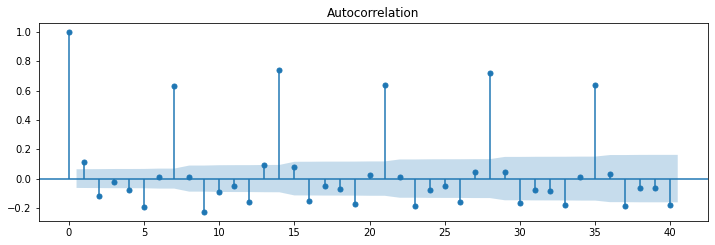

In [14]:
train_df = create_date_features(train_df)

train_df.sort_values(by=['Store','Date'],inplace=True)


# Check for direct and indirect seasonality 
df_Store = train_df.loc[train_df.Store==6,["Date","Sales"]]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(df_Store["Sales"],lags=40,ax=ax)



In [15]:
train_df = lag_features(train_df, [14, 30, 60,365])

alphas = [0.9, 0.8, 0.7, 0.5]
lags = [14, 35, 60,365]
train_df = ewm_features(train_df, alphas, lags)

train_df = roll_mean_features(train_df, [14, 30, 60,365])

In [16]:
train_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,sales_ewm_alpha_07_lag_60,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_35,sales_ewm_alpha_05_lag_60,sales_ewm_alpha_05_lag_365,sales_roll_mean_14,sales_roll_mean_30,sales_roll_mean_60,sales_roll_mean_365
1016271,1115,1,2015-07-27,10712,608,1,1,0,1,2015,...,6190.677460,2162.316325,6908.736209,4526.414092,5805.458807,3341.648129,5814.500000,5878.800000,5942.600000,5817.715068
1016270,1115,2,2015-07-28,8093,500,1,1,0,1,2015,...,7483.103238,6599.394897,7235.368104,4841.707046,6921.229404,5921.324064,5852.428571,6148.566667,5943.533333,5816.597260
1016269,1115,3,2015-07-29,7661,473,1,1,0,1,2015,...,8704.530971,7033.818469,6637.184052,5152.353523,8074.614702,6570.662032,5968.285714,6037.066667,5917.416667,5817.805479
1016268,1115,4,2015-07-30,8405,502,1,1,0,1,2015,...,2611.359291,7477.045541,6613.592026,5083.676761,4037.307351,7118.831016,6097.928571,6030.233333,6057.500000,5819.827397
1016267,1115,5,2015-07-31,8680,538,1,1,0,1,2015,...,6669.707787,7878.113662,7243.796013,5316.338381,6223.153675,7584.415508,6155.500000,6062.866667,6062.016667,5821.553425


# Training and testing with baseline model

In [17]:
train_df.set_index("Date",inplace=True)

In [18]:
# Spliting into features and target values and removing unneccasary columns
train_y = train_df["Sales"]

train_X = train_df.drop(columns=["Sales",'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval','PromoInterval','CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','day_name'])

train_X["StateHoliday"] = train_X["StateHoliday"].apply(str)
#train_X["Store"] = train_X["Store"].apply(str)

# Hot encoding categorical values
train_X = pd.get_dummies(train_X)
train_X['StateHoliday0'] = train_X['StateHoliday_0'].apply(int) + train_X['StateHoliday_0'].apply(int)
train_X.drop(columns='StateHoliday_0',inplace=True)


In [19]:
X_train = train_X.loc['2013-01-01':'2015-05-02']
X_test  = train_X.loc['2015-05-03':'2015-07-31']

y_train = train_y.loc['2013-01-01':'2015-05-02']
y_test  = train_y.loc['2015-05-03':'2015-07-31']


In [20]:
model = LGBMRegressor()

model.fit(X_train, y_train)

pred = model.predict(X_test)
pred[pred<=0] = 0

In [21]:
print('R2_score :',r2_score(y_test.values,pred))
print('Mean absolute error value :',mean_absolute_error(y_test.values,pred))

R2_score : 0.9654127996459239
Mean absolute error value : 479.65071790847196


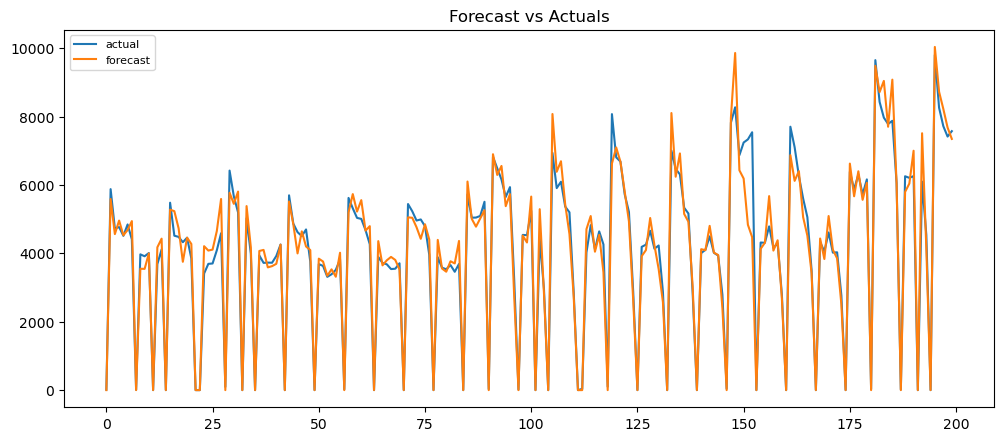

In [22]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(pred[:200], label='actual')
plt.plot(y_test.values[:200], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()